# Object tracking with event camera
In this exercise you will learn how to work with event based data similar to what you can find in a robotics and control type application. On the Canvas course page, you can find the recordings made from the week 3 Live session which covers the content you will need to know, introduces the exercise and the recordings you will use here. Please go through that material before and during your work in this exercise.

# Installation of dv-processing

`dv-processing` is a Python library of generic algorithms for event cameras, developed by inivation.


In [4]:
!pip install dv-processing
!pip install opencv-python
!pip install snntorch

## Content
1. **dataset folder:** this folder contains 14 recordings of a spinning wheel captured using and event camera. The dataset includes recordings under ideal conditions - with the camera positioned directly in front of the wheel with perfect calibration - and recordings with added noise introduced by altering the camera's position relative to the wheel. Specifically, the variations involve positioning the camera farther from the wheel, moving it closer, and shifting it away from the frontal position. For each record, there are two `aedat4` files associated, corresponding to a cropped rectangular area of 50x50 and 100x100 pixels.
2. **`exercise_utils.py`:** provides a collection of wrapper functions for the `dv-processing` library, designed to simplify the analysis of the dataset.
3. **`only_events.xml`:** this configuration file for [DV-GUI][3] allows users to preview event streams in saved in the `.aedat4` file format.
4. **`spinning_wheel_project_configuration.xml`:** this configuration file for [DV-GUI][3] enables users to preview `.aedat4` files containing event, frame, IMU, and trigger streams.
5. **`detected_angles.csv`** contains the angles extracted from `dvSave-2024_11_26_11_34_19.aedat4` as reference.

[1]: https://dv-processing.inivation.com/rel_1_7/installation.html
[2]: https://inivation.com/
[3]: https://docs.inivation.com/software/dv/gui/index.html

## Loading data

To load data originally recorded using the DVS camera, import the `exercise_utils` and use the function `load_data_from` indicating the path to the `aedat4` file.

In [5]:
import exercise_utils as utils

data = utils.load_data_from('dvSave-2024_11_26_11_34_19.aedat4')

In [6]:
data

## Extracting events

The original data contains the event, frame, IMU and trigger streams, you can use the `get_events_from` to extract the event stream. The `get_events_from` function, receives the data loaded from the `aedat4` file.

_**Note:**_ The crop files contains only an event stream.

In [7]:
events = utils.get_events_from(data)

In [8]:
events

EventStore containing 570461 events within 3449869µs duration; time range within [1732617259260540; 1732617262710409]

In [9]:
utils.events_info(events)['duration']

datetime.timedelta(seconds=3, microseconds=449869)

In [10]:
event = events[0]
print(event.x(), event.y(), event.polarity(), event.timestamp())


231 202 False 1732617259260540


In [11]:
for i in range(10):
  event = events[i]
  print(event.x(), event.y(), event.polarity(), event.timestamp())


231 202 False 1732617259260540
328 112 True 1732617259260628
6 167 True 1732617259260637
296 131 False 1732617259260684
231 202 False 1732617259260693
121 220 False 1732617259260727
231 202 False 1732617259260846
231 202 False 1732617259260998
182 74 False 1732617259261142
231 202 False 1732617259261151


# Task 1
Your first task is to estimate/calculate the angular position of the wheel in the recordings demoed in the Live session and provided in the appended datafiles, to later be used as ground thruth when training an SNN. For this you need to define a global starting angular position and create datapoints to be able to replicate this kind of figure:
![angle evolution](angles_evolution.png)

For this there are OpenCv functions which you can use, most importantly https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html and illustrated in the animated GIF below.
![fitted line](reference.gif)

In the cell below, develop a function for extracting the angular position of one of the recordings and plot the results in a similar way as the figure above.

In [12]:
### Your Task 1 code here ###
import numpy as np
import cv2
import dv_processing as dv
import matplotlib.pyplot as plt



def events_to_frame(events, width, height, frame_duration, t_start, t_end):
  frames = []
  t = t_start
  f = 0 # frame nr
  frame = np.zeros((height, width), dtype=np.uint8)
  for event in events:
    x, y, polarity, timestamp = event.x(), event.y(), event.polarity(), event.timestamp()
    if event.timestamp() - t <= frame_duration:
      frame[y, x] = 255  # Assuming binary event representation
    else:
      frames.append(frame)
      frame = np.zeros((height, width), dtype=np.uint8)
      f += 1
      t += f*frame_duration
  return frames

frame_width = 346
frame_height = 260 # get from utils

frame_duration = 10 # (0.01ms)
t_start = 1732617259260540
t_end = 1732617262710409

# Convert events to frame
frames = events_to_frame(events, frame_width, frame_height, frame_duration, t_start, t_end)



In [13]:
len(frames)

831

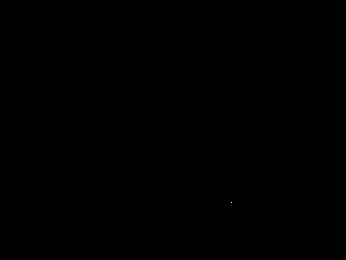

In [14]:
import numpy as np
import imageio
import matplotlib.pyplot as plt


# Save the frames as an animated GIF
imageio.mimsave('animation.gif', frames, duration=1)  # Duration is time between frames in seconds

# Display the GIF
from IPython.display import Image
Image(filename="animation.gif")




In [15]:
def detect_line(frame, show=False):
  frame_copy = frame.copy()
  height, width = frame_copy.shape[:2]
  # Apply Canny edge detection
  edges = cv2.Canny(frame_copy, 50, 150, apertureSize=3)

  # Use Hough Line Transform to detect lines
  lines = cv2.HoughLines(edges, 1, np.pi / 180, 100)

  # Draw the detected lines on the frame
  if lines is not None:
    for rho, theta in lines[:, 0]:
      a = np.cos(theta)
      b = np.sin(theta)
      x0 = a * rho
      y0 = b * rho
      x1 = int(x0 + 1000 * (-b))
      y1 = int(y0 + 1000 * (a))
      x2 = int(x0 - 1000 * (-b))
      y2 = int(y0 - 1000 * (a))

  # Calculate the angle of the detected line
  angular_position = np.nan
  if lines is not None:
    rho, theta = lines[0][0]
    angle_degrees = np.degrees(theta)

    # Adjust the angle based on the initial angle
    initial_angle = 0.0
    angular_position = (initial_angle + angle_degrees) % 360

    # print(f"Estimated Angular Position: {angular_position:.2f} degrees")

  if show:
    plt.figure(dpi=300)
    # Display the frame region using Matplotlib
    plt.imshow(frame_copy, cmap='gray')
    if lines is not None:
      x_values = (x1, x2)
      y_values = (y1, y2)
      plt.plot(x_values, y_values, color='r', linestyle='-', linewidth=2, label='Defined Line')
    plt.title('Detected Line')
    plt.xlim([0, width])
    plt.ylim([height, 0])  # Invert the y-axis to match the image coordinate system
        # Add a grid
    plt.grid(True, which='both', color='r', linestyle='--', linewidth=0.5)

    # Customize the grid intervals (optional)
    plt.gca().set_xticks(range(0, width, 5))  # Set x-ticks at intervals of 50 pixels
    plt.gca().set_yticks(range(0, height, 5))  # Set y-ticks at intervals of 50 pixels
    # Adjust the font size of the tick labels
    plt.tick_params(axis='both', which='major', labelsize=3)  # Change labelsize to a smaller value
    plt.show()
  return angular_position


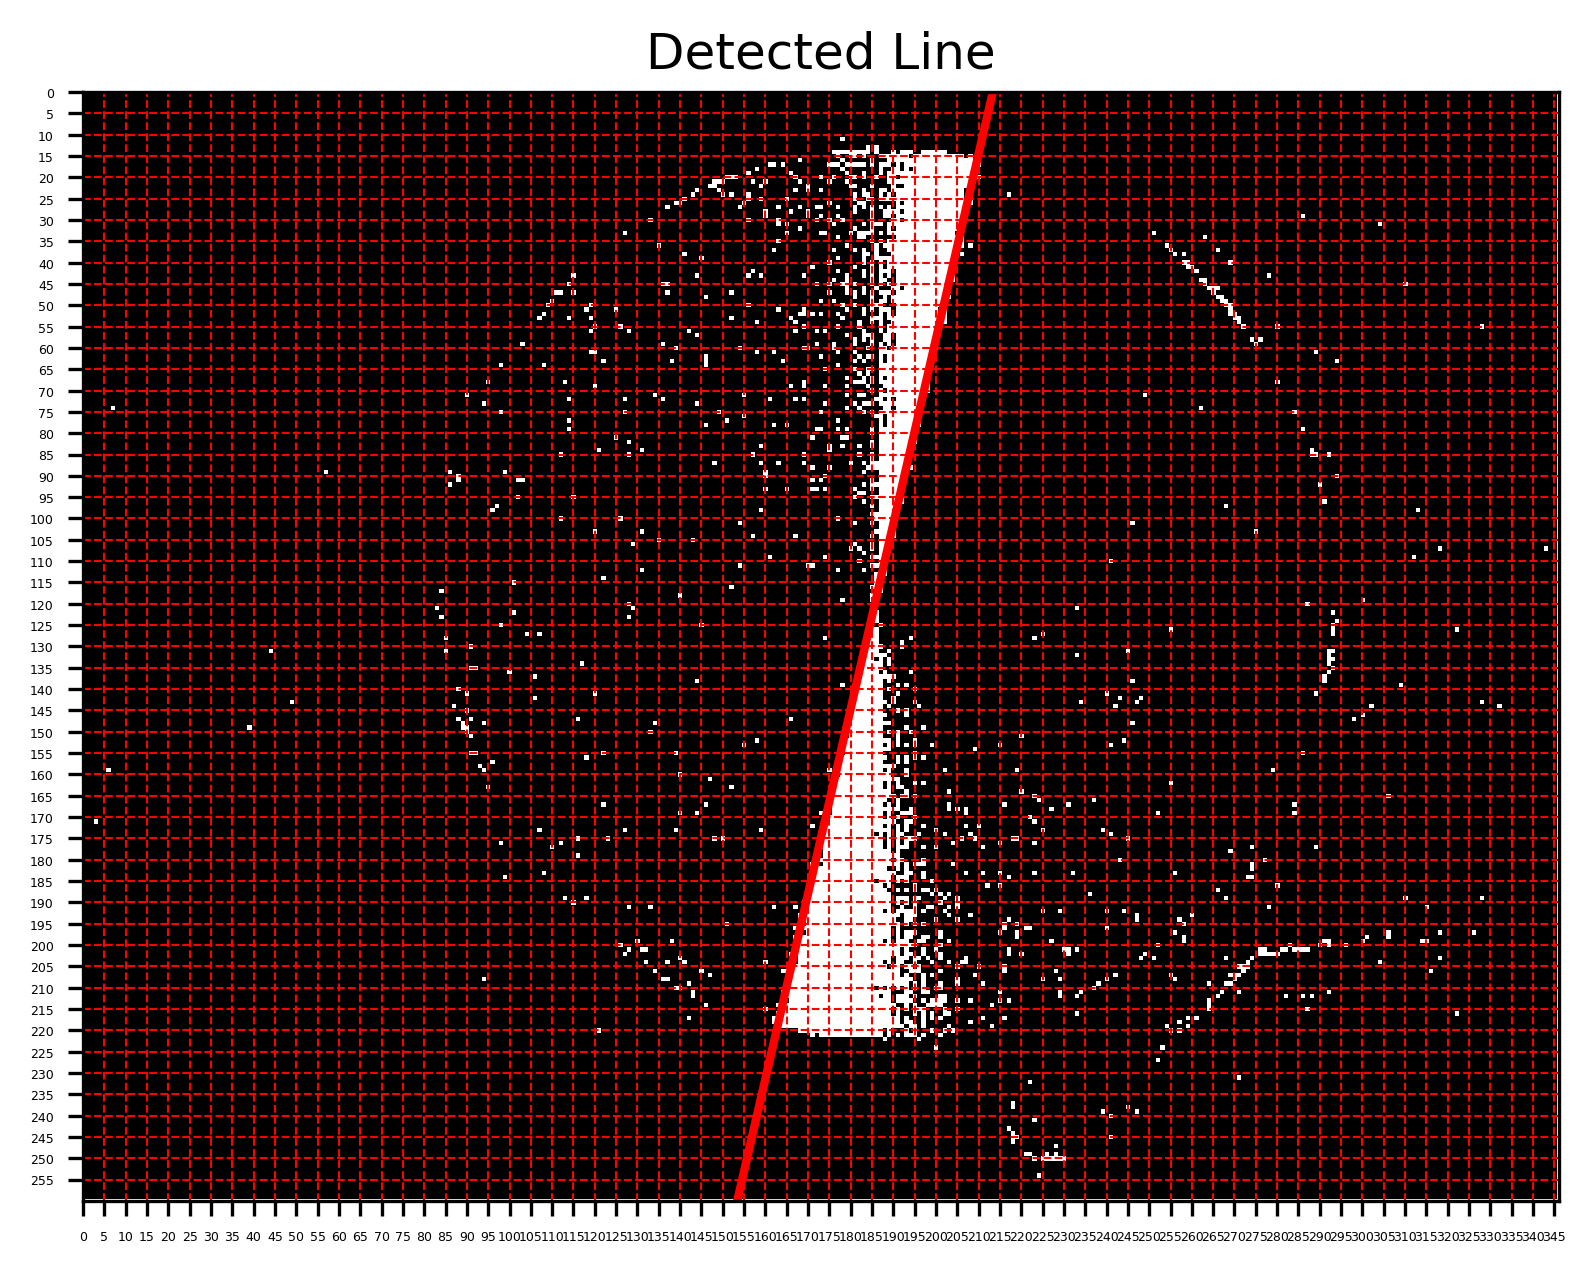

12.999999046325684

In [21]:
frame = frames[450]
detect_line(frame, True)

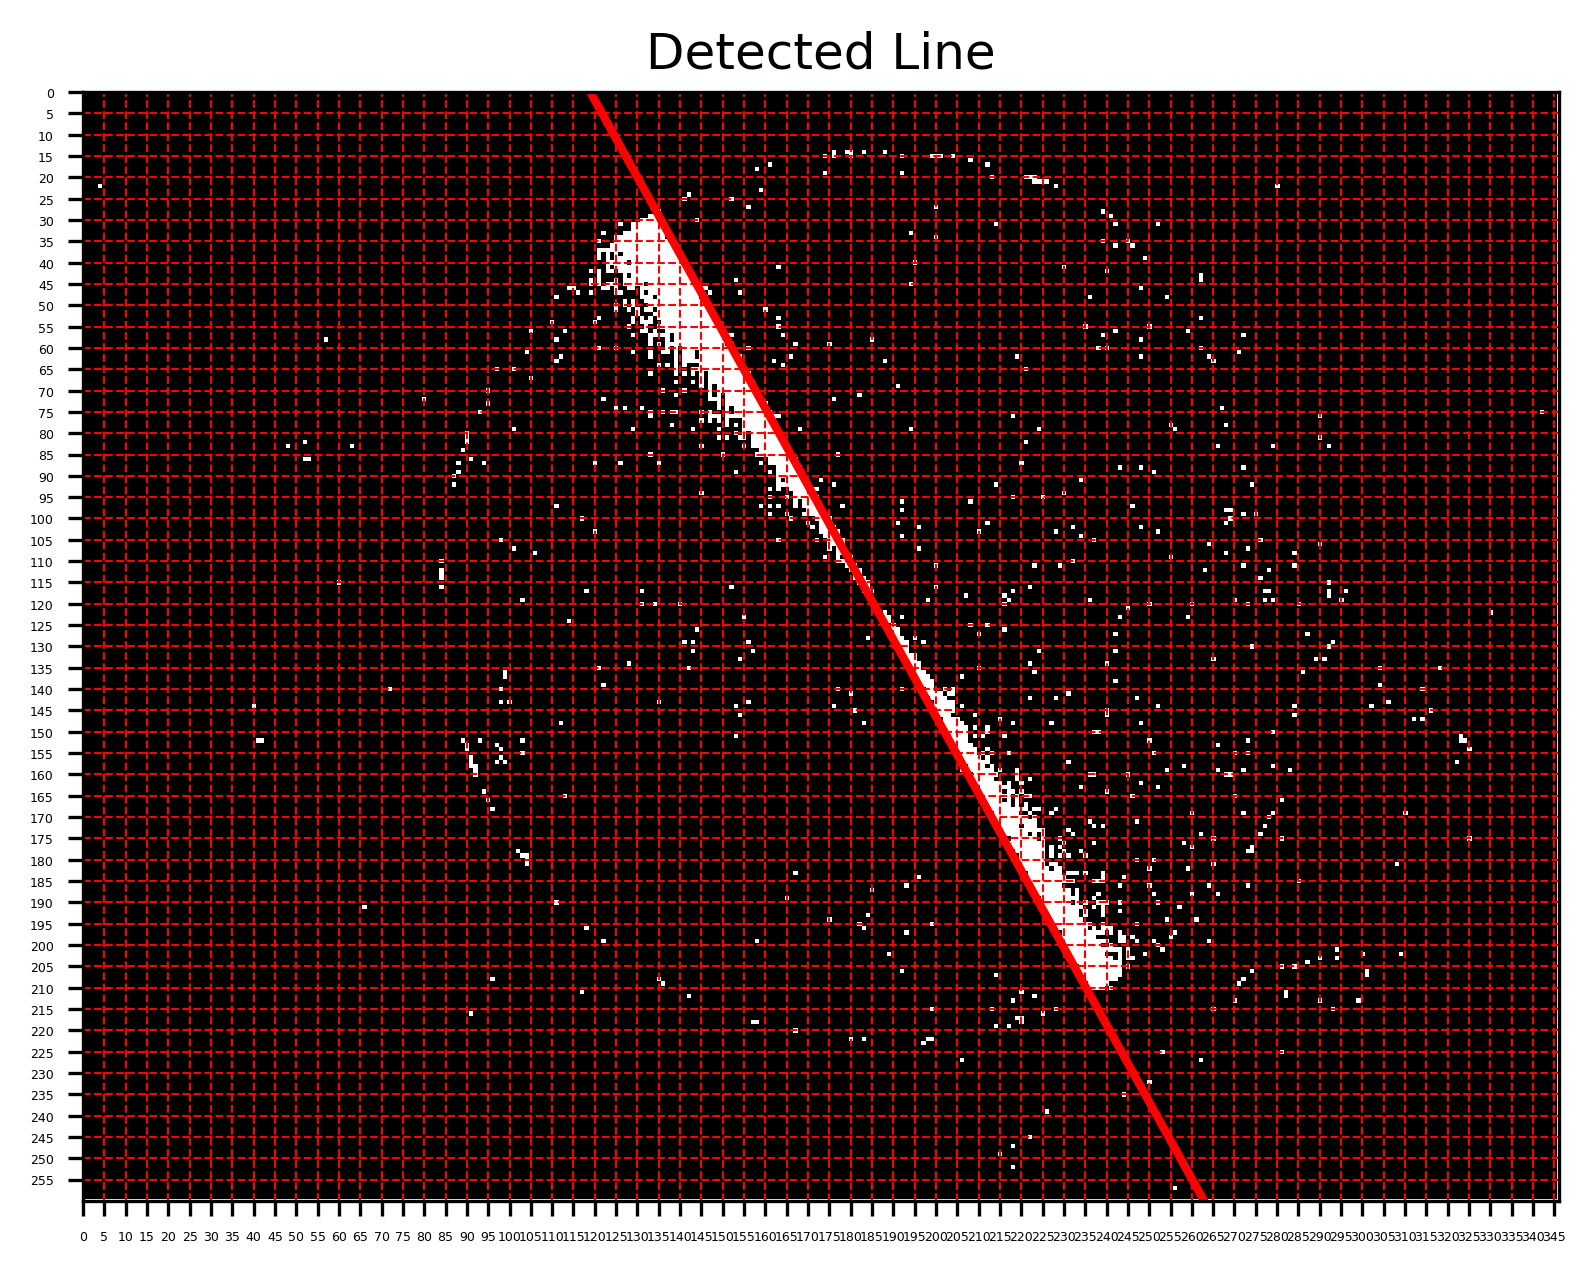

151.0

In [20]:
frame = frames[480]
detect_line(frame, True)

In [30]:
angles = []
for frame in frames:
  angle = detect_line(frame)
  angles.append(angle)

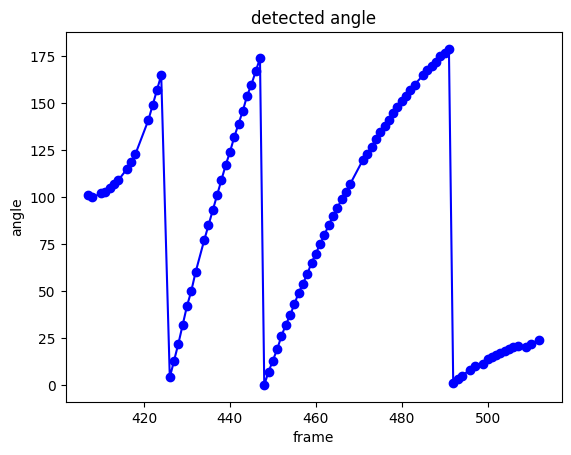

In [31]:
# Removing NaN values and storing the indices of valid values
indices = [i for i, val in enumerate(angles) if not np.isnan(val)]
valid_angles = [val for val in angles if not np.isnan(val)]

# Plotting
plt.plot(indices, valid_angles, marker='o', linestyle='-', color='b')
plt.xlabel('frame')
plt.ylabel('angle')
plt.title('detected angle')
plt.show()


In [32]:
### discard the none angles, valid data instance is 93 (93 frames will be used as the whole dataset)
len(valid_angles)

93

# Task 2
Perception is a key component of neuromorphic feedback control systems, similarly to what was shown in the Live session and which can be found here: https://arxiv.org/pdf/2108.03694. Here your task is to train an SNN which can estimate the position (angle) of the spinning wheel using events from a few pixels at the centre of the wheel as input to the network.  **Optionally** you can also estimate the angular velocity of the disk.

The number of pixels processed should be kept low to enable simulations on a regular PC/laptop, and also makes the problem more challenging compared to the approach in the first task where all event data is processed. By extracting a small region of pixels in the centre of the wheel you imitate the difficulty of identifying the angle of a wheel at great distance, where the size of the wheel only covers a small number of pixels. What factors determine the obtained precision and latency of the angle estimation? What are the options of output layers and definitions of the angle? How do you treat the discontinous nature of the angular position?

Thus, use the angle estimated in Task 1 as the ground truth for training an SNN that solves the regression problem. Remember to split the data into training and validation set of a suitable fraction (you do not need a test set for this exercise). Then plot the results of a given recoding together with the calculated ground thruth as a function of time. Also, calculate the RMS error and asses that your solution is reasonably accurate.

For this you can use what you learnt in the previous snnTorch exercise. Have a look at this tutorial (https://tonic.readthedocs.io/en/latest/tutorials/davis_data.html) on how to read your data into a similar format as used previouly with the pre-processing functionality used there (Hint: splice the recorded event stream into set time bins with corresponding ground truth from Task 1). The recordings have to be cropped quite heavily, as even an 50x50 input for example will result in 2500 input neurons which can be difficult to handle on a PC/laptop. In the exercise_utils.py file, there is a `crop_area` function which will achive this **where you need to give the center point of the circle**. To assist, the  `crop_preview_area` function can bee used for previewing the cropping of the recordings so you can check that your cropping is suitable.


In [ ]:
### What factors determine the obtained precision and latency of the angle estimation?
### 1 SNN Architecture: The number of layers, types of neurons, and connectivity, timestep numvber
### 2 Time window for the

###  What are the options of output layers and definitions of the angle
### output nr = 2, I convert angles to sine and cosine combination

In [24]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import snntorch as snn


import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
### crop area is set as 30x30 (20x20 is hard to train)
### 185 and 120 is getting from visual inspection of the centroid of the wheel
cropped_events = utils.crop_area('dvSave-2024_11_26_11_34_19.aedat4', (185, 120), 30, 30)


In [26]:
event = cropped_events[0]

print(event.x(), event.y(), event.polarity(), event.timestamp())

192 106 True 1732617259264605


In [27]:
def cropped_events_to_frame(events, frame_duration, t_start, t_end, crop_width=30, crop_height=30):
  frames = []
  t = t_start
  f = 0 # frame nr
  frame = np.zeros((crop_height, crop_width), dtype=np.uint8)
  for event in events:
    x, y, polarity, timestamp = event.x(), event.y(), event.polarity(), event.timestamp()
    if event.timestamp() - t <= frame_duration:

      frame[y-120+crop_height//2, x-185+crop_width//2] = 255  ### correspoinding x,y in 30x30 frame
    else:
      frames.append(frame)
      frame = np.zeros((crop_height, crop_width), dtype=np.uint8)
      f += 1
      t += f*frame_duration
  return frames

frame_width = 346
frame_height = 260 # get from utils

frame_duration = 10 # (0.01ms)
t_start = 1732617259260540
t_end = 1732617262710409

# Convert events to frame
cropped_frames = cropped_events_to_frame(cropped_events, frame_duration, t_start, t_end)

In [28]:
# check if the crop is correct

cropped_frames[450]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0, 255, 255, 255,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255,   0,
          0,   0, 255,   0, 255, 255, 255,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255,   0, 255,
          0,   0, 255,   0, 255, 255,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        255,   0,   0,   0, 255, 255,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0, 255,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255,
          0,   0,   0,   0, 255, 255,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 255,   0,   0,   0,   0,   0,
        255,   0,   0,   0, 255, 255,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0, 255, 255, 255,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0, 255, 255,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0, 255, 255,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 255, 255, 255,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0, 255, 255,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 255, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 255,   0,   0,   0,   0,
          0,   0, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 255, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 255,   0, 255,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 255, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 255, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,
    

In [33]:
# use frame 421-498 as valid dataset
# frame 421-471 as train set, frame 471-498 as validation set

train_x = [cropped_frames[i] for i in indices[:50]]
val_x = [cropped_frames[i] for i in indices[50:77]]
train_y = [angles[i] for i in indices[:50]]
val_y = [angles[i] for i in indices[50:77]]

In [78]:
###
def angle_to_sin_cos(angle):
    radians = torch.deg2rad(angle)
    return torch.sin(radians), torch.cos(radians)


train_y = [angle_to_sin_cos(torch.tensor(angle)) for angle in train_y]
val_y = [angle_to_sin_cos(torch.tensor(angle)) for angle in val_y]

In [154]:
train_y[0]

(tensor(0.9816, dtype=torch.float64), tensor(-0.1908, dtype=torch.float64))

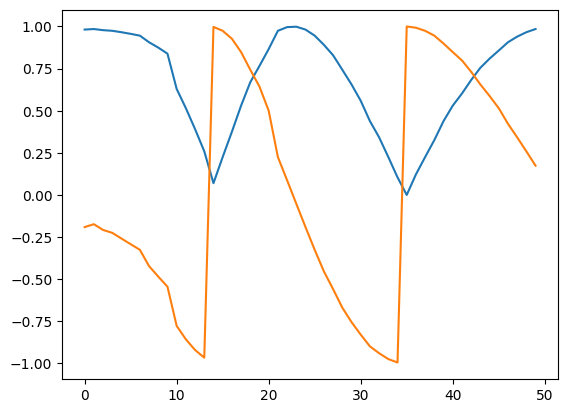

In [155]:
ys_sine = []
ys_cosine = []
for y in train_y:
  ys_sine.append(y[0])
  ys_cosine.append(y[1])
plt.plot(ys_sine)
plt.plot(ys_cosine)


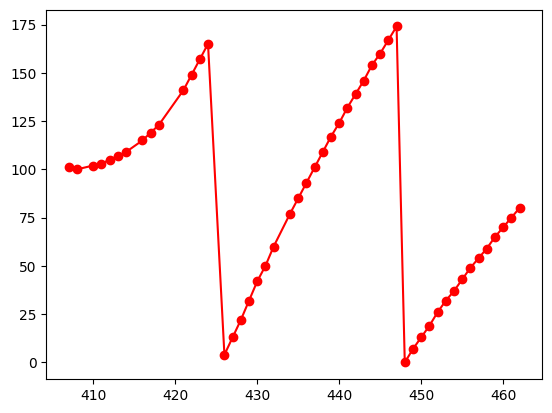

In [118]:
plt.plot(indices[:50], valid_angles[:50], marker='o', linestyle='-', color='r')

In [88]:
# Network Architecture
num_inputs = 30*30
num_hidden = 1000
num_outputs = 2
# Temporal Dynamics
num_steps = 30
beta = 0.95
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net()



In [80]:
loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-6, betas=(0.9, 0.999))

In [81]:

from torch.utils.data import Dataset, DataLoader

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data_list, labels_list):
        self.data_list = data_list
        self.labels_list = labels_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        data = torch.tensor(self.data_list[idx], dtype=torch.float32)
        label = torch.tensor(self.labels_list[idx], dtype=torch.float32)
        return data, label



# Create the dataset
train_dataset = CustomDataset(train_x, train_y)
val_dataset = CustomDataset(val_x, val_y)

# Create the dataloader with batch size
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [82]:
data, targets = next(iter(train_loader))

In [83]:
targets

tensor([[ 0.2250, -0.9744],
        [ 0.5150, -0.8572],
        [ 0.1219,  0.9925],
        [ 0.3420, -0.9397]])

In [183]:
spk_rec, mem_rec = net(data.view(batch_size, -1))
print(mem_rec.size())

torch.Size([10, 4, 2])


In [184]:
loss(mem_rec[0], targets)

tensor(0.7508, grad_fn=<MseLossBackward0>)

In [89]:
num_epochs = 30
loss_hist = []
test_loss_hist = []
counter = 0
dtype = torch.float

for epoch in range(num_epochs):
  train_batch = iter(train_loader)
  for data, targets in train_batch:

    # Forward pass
    net.train()
    spk_rec, mem_rec = net(data.view(batch_size, -1))

    # Initialize the loss & sum over time
    loss_val = torch.zeros((1), dtype=dtype)
    # for step in range(num_steps):
    #     loss_val += loss(mem_rec[step], targets)
    loss_val += loss(mem_rec[-1], targets)
    # Gradient calculation + weight update
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()

    # Store loss history for future plotting
    loss_hist.append(loss_val.item())

    # Test set evaluation
    with torch.no_grad():
        net.eval()
        test_data, test_targets = next(iter(val_loader))
        test_data = test_data.view(batch_size, -1)
        test_targets = test_targets.view(batch_size, -1)

        # Test set forward pass
        test_spk, test_mem = net(test_data)


        # Test set loss
        test_loss = torch.zeros((1), dtype=dtype)
        # for step in range(num_steps):
        #     test_loss += loss(test_mem[step], test_targets)
        test_loss += loss(test_mem[-1], test_targets)
        test_loss_hist.append(test_loss.item())

        # Print train/test loss/accuracy
        # if counter % 50 == 0:
        #     train_printer()
        counter += 1


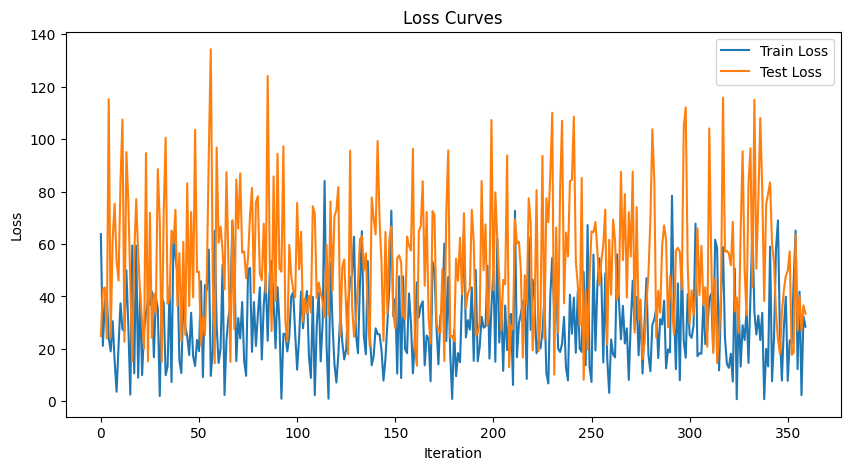

In [90]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [91]:
val_loader_1 = DataLoader(val_dataset, batch_size=1, shuffle=False, drop_last=False)

def sin_cos_to_angle(sin_val, cos_val):
    angle_rad = torch.atan2(sin_val, cos_val)  # Angle in radians
    angle_deg = torch.rad2deg(angle_rad)  # Convert to degrees


    return angle_deg

def sin_cos_to_angle1(sin_val, cos_val):
    angle_rad = torch.atan2(sin_val, cos_val)  # Angle in radians
    angle_deg = torch.rad2deg(angle_rad)  # Convert to degrees

    # Map angles to the [0, 180] range
    if angle_deg < 0:
        angle_deg += 360

    # Keep angles in the range [0, 180]
    angle_deg = angle_deg % 180

    return angle_deg

predicts = []
truth = []
with torch.no_grad():
  net.eval()
  for data, targets in val_loader_1:

    # forward pass
    val_spk, val_mem = net(data.view(data.size(0), -1))

    predicted_sin = val_mem[-1].squeeze()[0]
    predicted_cos = val_mem[-1].squeeze()[1]
    predicted_angle = sin_cos_to_angle1(predicted_sin, predicted_cos)
    predicts.append(predicted_angle)
    # true_angle = sin_cos_to_angle(targets.squeeze()[0], targets.squeeze()[1])

    # print(f'Predicted Angle: {predicted_angle} degrees')
    # print(f'True Angle: {true_angle} degrees')

true_angle = [angles[i] for i in indices[50:77]]
# Calculate the Mean Squared Error
mse = np.mean((np.array(true_angle) - np.array(predicts)) ** 2)

# Calculate the Root Mean Squared Error
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error: {rmse}')



Root Mean Squared Error: 59.829629134392576


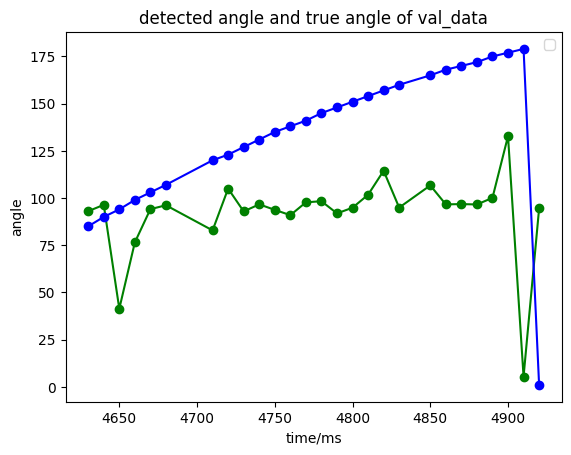

In [92]:
time_axis = [i*frame_duration for i in indices[50:77]]
# Plotting
plt.plot(time_axis, predicts, marker='o', linestyle='-', color='g')
plt.plot(time_axis, true_angle, marker='o', linestyle='-', color='b')
plt.xlabel('time/ms')
plt.ylabel('angle')
plt.title('detected angle and true angle of val_data')
plt.legend()
plt.show()


# -------------------------------------------------------------

Note: It is difficult with small crop size like 20x20, then I increase it to 30x30, the performance is better. Hidden size increase to 1500 also imporve the performance. I also tried different timestep numbers like 5, 10, 30. 30 gives the lowest validation RMS error. I have also tried calculate loss over all time steps or only the last step in this case, focusing on the last step which is the final output gives better result.